Utilizaremos un dataset generado sinteticamente con SciKit Learn

In [1]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=2000, n_features=20)
input_size = X.shape[1]
print(X.shape)
print(y.shape)

(2000, 20)
(2000,)


Hacemos el split de los conjuntos de training y test.

In [2]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, labels_train, labels_test = train_test_split(X, y, test_size=0.2, random_state = 42)
print(len(feature_train))
print(len(feature_test))

1600
400


Importamos PyTorch y almacenamos nuestros split del dataset en Tensores (Tipo de variables que procesa PyTorch)

In [3]:
import torch
import torch.nn as nn #PyTorch's module wrapper
import torch.optim as optim #PyTorch's optimiser
import torch.nn.functional as F
from torch.autograd import Variable #PyTorch's implementer of gradient descent and back propogation
import matplotlib.pyplot as plt #importing graph plotting functionality
%matplotlib inline

feature_train_v =  Variable(torch.from_numpy(feature_train).float())
labels_train_v =  Variable(torch.from_numpy(labels_train.reshape(-1, 1)).float())
feature_test_v =  Variable(torch.from_numpy(feature_test).float())
labels_test_v =  Variable(torch.from_numpy(labels_test).float())

print (feature_train_v[0])
print (labels_train_v[0])

tensor([ 1.5126, -1.3265,  0.6902, -1.2114,  0.9272,  0.4409, -0.1437, -0.9094,
         0.0413, -1.1474, -0.9255, -0.3206, -0.5760, -0.2354,  0.3289,  0.2457,
        -0.1384,  2.0491,  1.0413,  0.1690])
tensor([89.2217])


El modelo consiste:
* Una capada de entrada del tipo lineal (y=xA.T+b) con activación ReLU
* Una capa oculta con 20 neuronas de tipo lineal (y=xA.T+b) con activación ReLU
* Una capa de salida del tipo lineal (y=xA.T+b) con una unica neurona (Sin función de activación).

In [4]:
class Network(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(Network, self).__init__()        
        self.input_layer = nn.Linear(input_size, hidden_size) #y=xA.T+b
        self.hidden1_layer = nn.Linear(hidden_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, 1) 
        
    def forward(self,x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden1_layer(x))
        return self.output_layer(x)
    
hidden_neurons = 20    
model = Network(input_size, hidden_neurons)

# Inicializo los pesos de la red con inicialización xavier
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
model.apply(init_weights)

loss_fn = nn.SmoothL1Loss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

Entrenamos el modelo

In [5]:
all_losses = []
for num in range(5000): #epochs    
    optim.zero_grad() #zero gradients to not accumulate
    
    pred = model(feature_train_v) #predict
    loss = loss_fn(pred, labels_train_v) #calculate loss
    all_losses.append(loss.data)
    
    loss.backward() #update weights based on loss
    optim.step() #update optimiser for next iteration

Visualizamos la perdida durante el entrenamiento

In [6]:
import numpy as np

all_losses_np = np.array(all_losses, dtype = np.float)

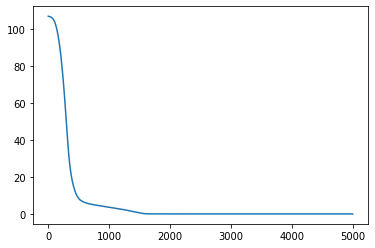

Training Loss:  tensor(5.7457e-06)


In [7]:
plt.plot(all_losses_np)
plt.show()

print('Training Loss: ', all_losses[-1])

Calculamos el score sobre el conjunto de test

In [8]:
from sklearn.metrics import r2_score
model.eval()
with torch.no_grad():
    pred = model(feature_test_v).detach().numpy()
    score = r2_score(labels_test, pred)
    print('R2 Score:', score)

R2 Score: 0.9999965055042481
